This is a version of object detection that goes through the thought process more in depth.

##### Step 1. Loading the Input image/s

In [1]:
# import dependencies 
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# SAM/OpenCLIP dependencies
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image as Image_Open
from PIL import Image
import open_clip

# COCO dependencies
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import json

Load COCO and initialize the labels from Val 2017 annotations

In [2]:
# Loading COCO
dataDir='..'
dataType='val2017'
annFile='{}/coco/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.58s)
creating index...
index created!


In [20]:
# display COCO categories and store them into array 'labels'. Tokenize the labels using OpenCLIP
cats = coco.loadCats(coco.getCatIds())
labels = [(cat['id'], cat['name']) for cat in cats]
labels_id = {id:label for id, label in labels}
print(labels_id)

# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc[1] for desc in labels])

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

Load input image using COCO

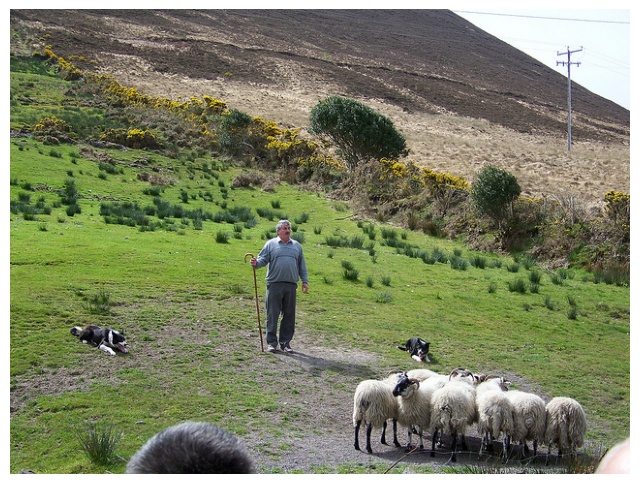

In [4]:
# randomly sample an image from COCO Val split 2017
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog']);
imgIds = coco.getImgIds(catIds=catIds );
# imgIds = coco.getImgIds(imgIds = [324158]) # uncomment to get a specific image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image_id = img['id']

# load and display image
image = io.imread(img['coco_url']) 

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image) 
plt.imshow(tempImg)
plt.axis('off')
plt.show() 

Load input image locally

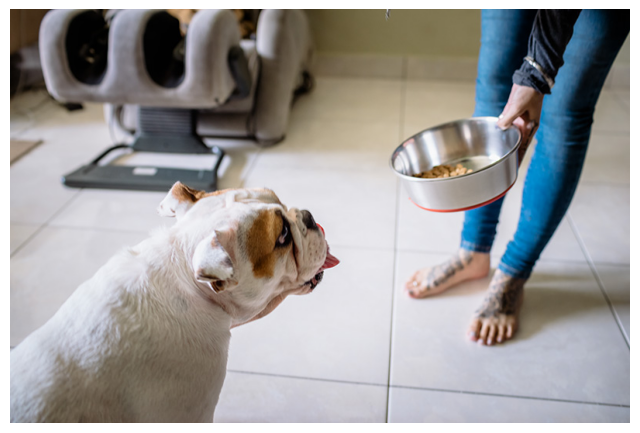

In [29]:
# load and display image
image = cv2.imread('images/dog.jpg') 
# convert image to be readable by SAM
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image)
plt.imshow(tempImg)
plt.axis('off')
plt.show() 

##### Step 2. Segment Anything Output

In [5]:
# Loading SAM Model
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictors
mask_generator = SamAutomaticMaskGenerator(sam) # automatic
predictor = SamPredictor(sam) # manual

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [7]:
# Run automatic mask generation
masks = mask_generator.generate(image)
length_masks = len(masks)

In [8]:
# Loading OpenCLIP
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

##### Step 3. Cropping the image depending on the SAM output (masks)

In [9]:
def get_cropped_image(mask):
    # convert the XYWH bounding box to LURD format
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], 
    bbox_xywh[1] + bbox_xywh[3]] # convert the bounding box to LURD format
    
    # Crop the image using the bounding box coordinates
    cropped_image = tempImg.crop(bbox_lurd) 
    display_image = cropped_image.convert("RGB")
    cropped_image = transform(display_image).unsqueeze(0)
    
    return cropped_image, display_image

##### Step 4. Getting the output label prediction from openCLIP.

In [10]:
# Run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
def get_label(mask):
    # crop the image AKA get the bounding box
    cropped_image, display_image = get_cropped_image(mask)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        text_features = model.encode_text(labels_tokenized).float()
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)
    
    # return the highest probability label and its percentage
    return labels[top_labels[0][0].item()], top_probs[0][0].item(), labels[top_labels[0][1].item()], top_probs[0][1].item()

In [12]:
# create a dictionary of labels and the corresponding probabilities
label_dict = []

# iterate through all the masks and get the top 2 labels for each mask
for mask in range(length_masks):
    label1, probability1, label2, probability2 = get_label(mask)
    label_dict.append({"category_id": label1[0], 
                       "bbox": masks[mask]['bbox'], "score": probability1})
    label_dict.append({"category_id": label2[0], 
                       "bbox": masks[mask]['bbox'], "score": probability2})

In [13]:
#label_dict = [{'image_id': 80153, 'category_id': 35, 'bbox': [0, 81, 427, 558], 'score': 0.9992744326591492}, {'image_id': 80153, 'category_id': 36, 'bbox': [0, 0, 427, 91], 'score': 0.6077811121940613}, {'image_id': 80153, 'category_id': 35, 'bbox': [202, 150, 85, 188], 'score': 0.8669075965881348}, {'image_id': 80153, 'category_id': 74, 'bbox': [187, 126, 49, 34], 'score': 0.24133776128292084}, {'image_id': 80153, 'category_id': 35, 'bbox': [151, 126, 150, 409], 'score': 0.9994683861732483}, {'image_id': 80153, 'category_id': 35, 'bbox': [187, 126, 114, 286], 'score': 0.9978146553039551}, {'image_id': 80153, 'category_id': 18, 'bbox': [206, 362, 83, 173], 'score': 0.5803560018539429}, {'image_id': 80153, 'category_id': 65, 'bbox': [251, 380, 24, 17], 'score': 0.24015702307224274}, {'image_id': 80153, 'category_id': 1, 'bbox': [233, 307, 51, 42], 'score': 0.26342251896858215}, {'image_id': 80153, 'category_id': 36, 'bbox': [0, 69, 169, 117], 'score': 0.5160307884216309}, {'image_id': 80153, 'category_id': 39, 'bbox': [251, 380, 24, 33], 'score': 0.23950086534023285}, {'image_id': 80153, 'category_id': 1, 'bbox': [417, 24, 10, 13], 'score': 0.19869676232337952}, {'image_id': 80153, 'category_id': 35, 'bbox': [226, 290, 58, 95], 'score': 0.5034642815589905}, {'image_id': 80153, 'category_id': 15, 'bbox': [326, 108, 47, 47], 'score': 0.2462030053138733}, {'image_id': 80153, 'category_id': 18, 'bbox': [72, 454, 221, 185], 'score': 0.8178400993347168}, {'image_id': 80153, 'category_id': 63, 'bbox': [234, 344, 40, 41], 'score': 0.17686030268669128}, {'image_id': 80153, 'category_id': 1, 'bbox': [190, 150, 24, 32], 'score': 0.8841147422790527}, {'image_id': 80153, 'category_id': 39, 'bbox': [261, 391, 14, 22], 'score': 0.08251822739839554}, {'image_id': 80153, 'category_id': 35, 'bbox': [387, 46, 27, 33], 'score': 0.255812406539917}, {'image_id': 80153, 'category_id': 85, 'bbox': [347, 67, 13, 34], 'score': 0.06912384182214737}, {'image_id': 80153, 'category_id': 72, 'bbox': [296, 107, 15, 24], 'score': 0.1121295839548111}, {'image_id': 80153, 'category_id': 32, 'bbox': [233, 316, 41, 69], 'score': 0.11272279918193817}, {'image_id': 80153, 'category_id': 1, 'bbox': [387, 79, 15, 48], 'score': 0.34468522667884827}, {'image_id': 80153, 'category_id': 6, 'bbox': [329, 80, 9, 16], 'score': 0.12406154721975327}, {'image_id': 80153, 'category_id': 1, 'bbox': [409, 60, 18, 83], 'score': 0.11215370148420334}, {'image_id': 80153, 'category_id': 16, 'bbox': [242, 86, 24, 72], 'score': 0.1237453892827034}, {'image_id': 80153, 'category_id': 35, 'bbox': [372, 79, 30, 47], 'score': 0.6107750535011292}, {'image_id': 80153, 'category_id': 72, 'bbox': [51, 140, 31, 16], 'score': 0.06565067172050476}, {'image_id': 80153, 'category_id': 5, 'bbox': [11, 283, 21, 12], 'score': 0.1153164952993393}, {'image_id': 80153, 'category_id': 42, 'bbox': [46, 205, 17, 9], 'score': 0.09783181548118591}, {'image_id': 80153, 'category_id': 18, 'bbox': [205, 361, 59, 74], 'score': 0.9735325574874878}, {'image_id': 80153, 'category_id': 3, 'bbox': [174, 109, 35, 9], 'score': 0.37489190697669983}, {'image_id': 80153, 'category_id': 35, 'bbox': [293, 467, 107, 34], 'score': 0.5568870306015015}, {'image_id': 80153, 'category_id': 1, 'bbox': [342, 108, 4, 9], 'score': 0.26104986667633057}, {'image_id': 80153, 'category_id': 5, 'bbox': [75, 230, 11, 10], 'score': 0.16270121932029724}, {'image_id': 80153, 'category_id': 42, 'bbox': [172, 108, 47, 12], 'score': 0.736384391784668}, {'image_id': 80153, 'category_id': 72, 'bbox': [371, 79, 16, 31], 'score': 0.16257144510746002}, {'image_id': 80153, 'category_id': 39, 'bbox': [271, 334, 21, 30], 'score': 0.12302891910076141}, {'image_id': 80153, 'category_id': 42, 'bbox': [111, 389, 96, 12], 'score': 0.2338147908449173}, {'image_id': 80153, 'category_id': 77, 'bbox': [233, 408, 50, 25], 'score': 0.5319007039070129}, {'image_id': 80153, 'category_id': 3, 'bbox': [49, 181, 25, 10], 'score': 0.08356828987598419}, {'image_id': 80153, 'category_id': 16, 'bbox': [20, 234, 18, 16], 'score': 0.18542104959487915}, {'image_id': 80153, 'category_id': 62, 'bbox': [271, 333, 17, 20], 'score': 0.29896634817123413}, {'image_id': 80153, 'category_id': 1, 'bbox': [246, 67, 5, 4], 'score': 0.13703912496566772}, {'image_id': 80153, 'category_id': 1, 'bbox': [112, 201, 3, 8], 'score': 0.3174571692943573}, {'image_id': 80153, 'category_id': 35, 'bbox': [299, 78, 35, 27], 'score': 0.2851182520389557}, {'image_id': 80153, 'category_id': 1, 'bbox': [176, 87, 5, 4], 'score': 0.30611705780029297}, {'image_id': 80153, 'category_id': 35, 'bbox': [177, 287, 46, 85], 'score': 0.9533762335777283}, {'image_id': 80153, 'category_id': 1, 'bbox': [61, 249, 4, 5], 'score': 0.19551792740821838}, {'image_id': 80153, 'category_id': 5, 'bbox': [34, 251, 16, 13], 'score': 0.11174891889095306}, {'image_id': 80153, 'category_id': 72, 'bbox': [387, 63, 14, 17], 'score': 0.09503377228975296}, {'image_id': 80153, 'category_id': 35, 'bbox': [271, 334, 30, 49], 'score': 0.12780356407165527}, {'image_id': 80153, 'category_id': 39, 'bbox': [292, 202, 19, 15], 'score': 0.11434153467416763}, {'image_id': 80153, 'category_id': 42, 'bbox': [183, 108, 35, 10], 'score': 0.2893866300582886}]
print(label_dict)

[{'category_id': 11, 'bbox': [458, 0, 181, 131], 'score': 0.16917993128299713}, {'category_id': 1, 'bbox': [458, 0, 181, 131], 'score': 0.15800434350967407}, {'category_id': 17, 'bbox': [120, 426, 132, 53], 'score': 0.5072355270385742}, {'category_id': 20, 'bbox': [120, 426, 132, 53], 'score': 0.12967315316200256}, {'category_id': 64, 'bbox': [0, 0, 639, 196], 'score': 0.5021554231643677}, {'category_id': 11, 'bbox': [0, 0, 639, 196], 'score': 0.10689201205968857}, {'category_id': 1, 'bbox': [254, 234, 53, 48], 'score': 0.7444554567337036}, {'category_id': 34, 'bbox': [254, 234, 53, 48], 'score': 0.10980759561061859}, {'category_id': 24, 'bbox': [0, 0, 639, 136], 'score': 0.15642961859703064}, {'category_id': 1, 'bbox': [0, 0, 639, 136], 'score': 0.12106680124998093}, {'category_id': 64, 'bbox': [309, 89, 99, 75], 'score': 0.9715973138809204}, {'category_id': 15, 'bbox': [309, 89, 99, 75], 'score': 0.006859556771814823}, {'category_id': 39, 'bbox': [264, 282, 31, 66], 'score': 0.308280

In [14]:
# Gather all the bbox's for one category to be used for batched prompt inputs
from collections import defaultdict

boxes_dict = defaultdict(list)
for item in label_dict:
    boxes_dict[item['category_id']].append(item['bbox'])

for category_id, boxes in boxes_dict.items():
    tensor_name = f"{category_id}_boxes"
    tensor_value = torch.tensor(boxes)
    globals()[tensor_name] = tensor_value

In [15]:
# sort the boxes_dict and then store into tensor_array
tensor_array = []
def sort_bbox(boxes_dict):
    for category_id in boxes_dict.keys():
        tensor_name = f"{category_id}_boxes"
        if tensor_name in globals():
            tensor_value = globals()[tensor_name]
            tensor_array.append({tensor_name: tensor_value})
            print(f"{tensor_name}: {tensor_value}")

sort_bbox(boxes_dict)

11_boxes: tensor([[458,   0, 181, 131],
        [  0,   0, 639, 196],
        [476, 161,  74,  88]])
1_boxes: tensor([[458,   0, 181, 131],
        [254, 234,  53,  48],
        [  0,   0, 639, 136],
        [248, 217,  59, 137],
        [476, 161,  50,  64],
        [399, 339,  34,  25],
        [  0,   0, 639, 368],
        [269, 196,  10,   9],
        [424, 164,  50,  48],
        [513, 277,  20,  16],
        [131, 168,  41,  14],
        [410, 211,  12,  17],
        [120, 124,  32,  19],
        [137, 183,  18,   9],
        [ 93, 123,  28,  17],
        [529, 303,   9,   8],
        [  8, 189,  12,  10],
        [ 49, 214,   8,   6],
        [475, 255,  16,  12],
        [343, 268,  16,  12],
        [129, 425,  10,   3],
        [ 25, 111,  37,  15],
        [604, 302,  14,   9],
        [ 44, 198,   8,   6],
        [383, 226,  15,  11],
        [229, 168,  33,  15],
        [435, 246,  16,  16],
        [ 24,  38,  50,  35],
        [404, 230,   5,   7],
        [602, 260,  

In [16]:
# iterate through tensor_array and then create a batched prompt for each category
predictor.set_image(image)

In [22]:
input_boxes = torch.tensor([[131, 168,  13,   9],
        [279, 344,  12,  10]], device=predictor.device)

In [23]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

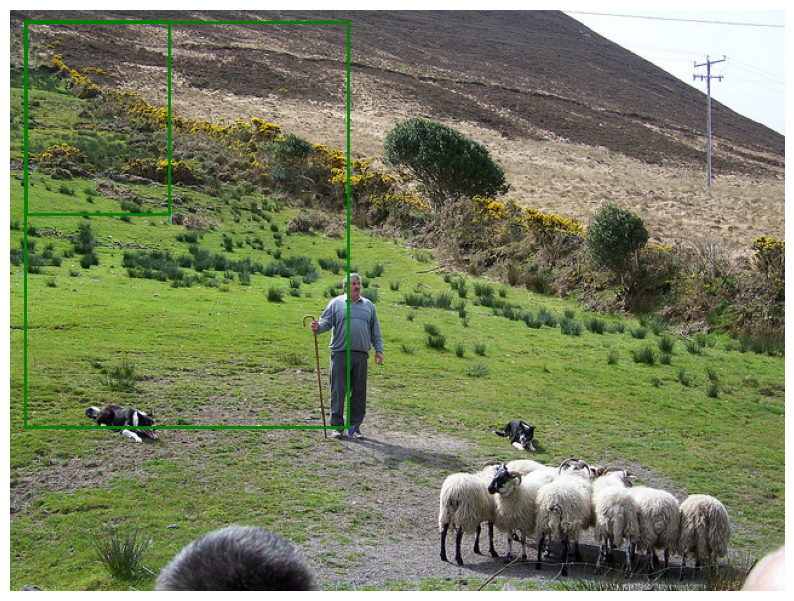

dining table


In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()
print(labels_id.get(67))

In [33]:
print(labels)

[(1, 'person'), (2, 'bicycle'), (3, 'car'), (4, 'motorcycle'), (5, 'airplane'), (6, 'bus'), (7, 'train'), (8, 'truck'), (9, 'boat'), (10, 'traffic light'), (11, 'fire hydrant'), (13, 'stop sign'), (14, 'parking meter'), (15, 'bench'), (16, 'bird'), (17, 'cat'), (18, 'dog'), (19, 'horse'), (20, 'sheep'), (21, 'cow'), (22, 'elephant'), (23, 'bear'), (24, 'zebra'), (25, 'giraffe'), (27, 'backpack'), (28, 'umbrella'), (31, 'handbag'), (32, 'tie'), (33, 'suitcase'), (34, 'frisbee'), (35, 'skis'), (36, 'snowboard'), (37, 'sports ball'), (38, 'kite'), (39, 'baseball bat'), (40, 'baseball glove'), (41, 'skateboard'), (42, 'surfboard'), (43, 'tennis racket'), (44, 'bottle'), (46, 'wine glass'), (47, 'cup'), (48, 'fork'), (49, 'knife'), (50, 'spoon'), (51, 'bowl'), (52, 'banana'), (53, 'apple'), (54, 'sandwich'), (55, 'orange'), (56, 'broccoli'), (57, 'carrot'), (58, 'hot dog'), (59, 'pizza'), (60, 'donut'), (61, 'cake'), (62, 'chair'), (63, 'couch'), (64, 'potted plant'), (65, 'bed'), (67, 'din

In [2]:
print(label_dict)

[{'category_id': 18, 'bbox': [0, 223, 422, 309], 'score': 0.9790651798248291}]


##### Step 5. If label is in COCO: compare prediction with ground truth score using mAP, Else: ignore

In [ ]:
# import dependencies for COCO evaluation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

Running demo for *bbox* results.


In [ ]:
#initialize COCO ground truth api
dataDir='../'
dataType='val2017'
prefix = 'instances'
annFile = '%s/coco/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


In [ ]:
# initialize COCO detections api
resFile='%s/coco/results/%s_%s_fake%s100_results.json'%(dataDir, prefix, dataType, annType)

# save the label_dict to a json file
with open(resFile, 'w') as f:
    json.dump(label_dict, f)

# load results in COCO evaluation tool    
cocoDt=cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [ ]:
imgIds=sorted(cocoGt.getImgIds())
imgIds=imgIds[0:100]
imgId = imgIds[np.random.randint(100)]

In [ ]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100